<a href="https://colab.research.google.com/github/nazmulhudabadhon/Computer-Vision-and-Deep-Learning-in-Medical-Imaging/blob/main/Lung%E2%80%93Colon%20Histopathology%3A%20Image%20Enhancement%20%26%20Transfer%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lung Colon ClassificationLung–Colon Histopathology: Image Enhancement & Transfer Learning, by Nazmul Huda Badhon

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


unzipping files

In [ ]:
import zipfile
import glob

zip_file = glob.glob('/content/drive/MyDrive/dataset/lung_colon_image_set.zip')

for file in zip_file:
    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('/content/lung_colon_data')

print('dataset extracted successfully')

dataset extracted successfully


Folder 'colon_aca' contains 5000 files.
Folder 'colon_n' contains 5000 files.
Folder 'lung_aca' contains 5000 files.
Folder 'lung_n' contains 5000 files.
Folder 'lung_scc' contains 5000 files.


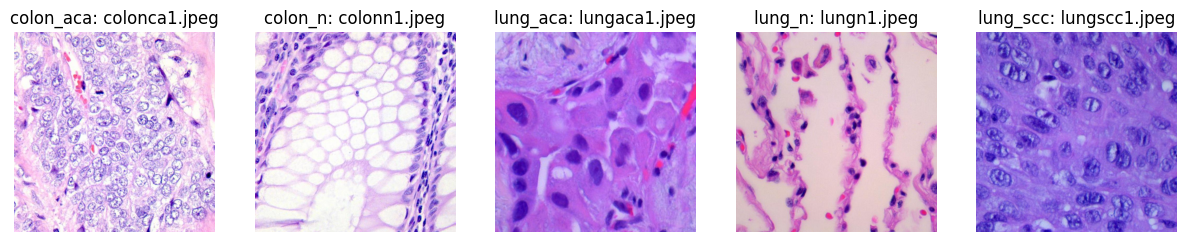

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

base_image_path = '/content/lung_colon_data/lung_colon_image_set'
subfolders = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

fig, axes = plt.subplots(1, 5, figsize=(15, 5))  # 1 row, 5 columns

# Iterate through subfolders and plot one image from each
for i, subfolder in enumerate(subfolders):
    folder_path = os.path.join(base_image_path, subfolder)
    file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    print(f"Folder '{subfolder}' contains {file_count} files.")

    input_path = os.path.join(base_image_path, subfolder)

    # Get a list of image files and sort them
    image_files = [f.path for f in os.scandir(input_path) if f.is_file()]
    image_files.sort()

    # Get the first image file (after sorting)
    image_file = image_files[0]
    image_name = os.path.basename(image_file)  # Get the image file name

    # Read and display the image
    image = cv2.imread(image_file)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
    axes[i].imshow(image_rgb)
    axes[i].set_title(subfolder)
    axes[i].set_title(f"{subfolder}: {image_name}")  # Include image name in title
    axes[i].axis('off')  # Turn off axis ticks and labels

plt.show()

# Part 01: Image Processing





# *Image Preprocessing trials on single image*

Three Image Processing techniques have been applied here. Those are given below sequentially.

............................................................................... Image Segmentation .....................................................................................

a) Binary Thresholding

b) Bitwise_and segmentation (To calculate metrics like: mse, rmse, psnr, ssim)

c) Inverted Segmentation (Input as Transfer Learning Models)

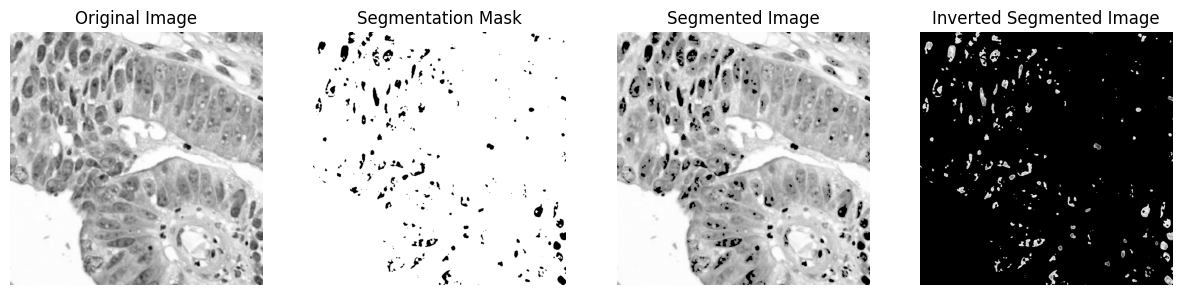

True

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

img = cv.imread('/content/lung_colon_data/lung_colon_image_set/colon_aca/colonca1002.jpeg',0)

# Applying Gaussian blur for noise reduction
img = cv2.GaussianBlur(img, (5, 5), 0)
_, mask = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)

# Create segmented image
segmented_img = cv2.bitwise_and(img, img, mask=mask)

# 1. Invert the mask
inverted_mask = cv2.bitwise_not(mask)

# 2. Apply the inverted mask
inverted_segmented_img = cv2.bitwise_and(img, img, mask=inverted_mask)

# Display images
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(mask, cmap='gray')
plt.title('Segmentation Mask')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(segmented_img, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(inverted_segmented_img, cmap='gray')
plt.title('Inverted Segmented Image')
plt.axis('off')

plt.show()

cv2.imwrite('segmented_image.jpg', segmented_img)

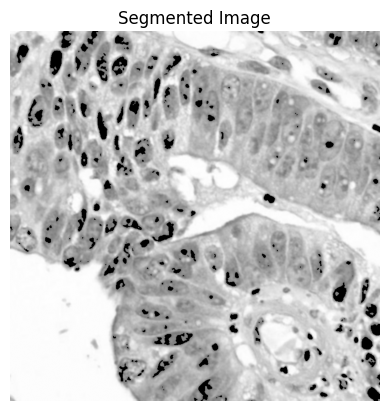

In [ ]:
plt.title('Segmented Image')
plt.imshow(segmented_img, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import shutil
from PIL import Image
from PIL import Image,ImageEnhance
from skimage import metrics
from skimage.metrics import structural_similarity as ssim

ref_img = cv2.imread("/content/lung_colon_data/lung_colon_image_set/colon_aca/colonca1002.jpeg", 1)  # Original image
img = cv2.imread("/content/segmented_image.jpg", 1)       # Processed image

assert ref_img.shape == img.shape, "Images must have the same dimensions!"

mse_skimg = metrics.mean_squared_error(ref_img, img)
print("MSE: based on scikit-image =", mse_skimg / 100)

psnr_skimg = metrics.peak_signal_noise_ratio(ref_img, img, data_range=None)
print("PSNR: based on scikit-image =", psnr_skimg)

min_dim = min(ref_img.shape[0], ref_img.shape[1])

if min_dim < 7:
    win_size = min_dim
else:
    win_size = 7

ssim_skimg = ssim(
        ref_img,
        img,
        data_range=img.max() - img.min(),
        multichannel=True,
        win_size=win_size,
        channel_axis=2,
    )
print("SSIM: based on scikit-image =", ssim_skimg)

rmse_f = np.sqrt(mse_skimg / 100)
print("RMSE:", rmse_f)

MSE: based on scikit-image = 14.198020952012802
PSNR: based on scikit-image = 16.60852548141134
SSIM: based on scikit-image = 0.8380861582185379
RMSE: 3.7680261347305968


# Applying all the preprocessing steps to the whole dataset (Getting Segemented Image)


In [ ]:
import os
import cv2
import numpy as np

# Paths
base_image_path = '/content/lung_colon_data/lung_colon_image_set'
subfolders = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']
output_dir = '/content/drive/MyDrive/dataset/preprocessed_dataset'

os.makedirs(output_dir, exist_ok=True)

def preprocess_image(image_path, output_path):
   """Applies preprocessing (segmentation) and saves the image."""
   img = cv2.imread(image_path, 0)
   img = cv2.GaussianBlur(img, (5, 5), 0)
   _, mask = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)
   segmented_img = cv2.bitwise_and(img, img, mask=mask)

   cv2.imwrite(output_path, segmented_img) # Save the  preprocessed image

for subfolder in subfolders:
   input_folder = os.path.join(base_image_path, subfolder)
   output_subfolder = os.path.join(output_dir, subfolder)
   os.makedirs(output_subfolder, exist_ok=True)

   for filename in os.listdir(input_folder):
     if filename.endswith((".jpg", ".jpeg", ".png")):
       image_path = os.path.join(input_folder, filename)
       output_path = os.path.join(output_subfolder, filename)
       preprocess_image(image_path, output_path)

print("Preprocessing complete. Images saved in:", output_dir)

Preprocessing complete. Images saved in: /content/drive/MyDrive/dataset/preprocessed_dataset


In [ ]:
for subfolder in subfolders:
  folder_path = os.path.join(output_dir, subfolder)
  file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
  print(f"Folder '{subfolder}' contains {file_count} files.")

Folder 'colon_aca' contains 5000 files.
Folder 'colon_n' contains 5000 files.
Folder 'lung_aca' contains 5000 files.
Folder 'lung_n' contains 5000 files.
Folder 'lung_scc' contains 5000 files.


# Extracting the PSNR, SSIM, MSE, and RMSE values for each image, saving the values in a DataFrame, and export it as a CSV file

In [ ]:
from skimage import metrics
from skimage.metrics import structural_similarity as ssim
import pandas as pd
from tqdm import tqdm

# Define paths
dataset_path = "/content/lung_colon_data/lung_colon_image_set"  # Path to original dataset
lungcolon_path = "/content/drive/MyDrive/dataset/preprocessed_dataset"  # Path to processed dataset
subfolders = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

# Initialize list to store results
results = []

# Function to compute metrics
def compute_metrics(ref_img, img):
    mse = (metrics.mean_squared_error(ref_img, img)) / 100
    psnr = metrics.peak_signal_noise_ratio(ref_img, img, data_range=None)

    # Get the smallest dimension of the image (height or width)
    min_dim = min(ref_img.shape[0], ref_img.shape[1])

    # Dynamically set win_size based on min_dim (must be odd and smaller than image dimensions)
    if min_dim < 7:
        win_size = min_dim  # Use the smallest dimension if it's less than 7
    else:
        win_size = 7  # Default value for larger images
    ssim_value = ssim(ref_img, img, data_range=img.max() - img.min(), channel_axis=2, win_size=win_size)

    rmse = np.sqrt(mse)
    return mse, psnr, ssim_value, rmse

# Iterate through each subfolder
for subfolder in subfolders:
    original_folder = os.path.join(dataset_path, subfolder)
    processed_folder = os.path.join(lungcolon_path, subfolder)

    # Iterate through each image in the subfolder
    for filename in tqdm(os.listdir(original_folder), desc=f"Processing {subfolder}"):
        original_image_path = os.path.join(original_folder, filename)
        processed_image_path = os.path.join(processed_folder, filename)

        # Check if both images exist
        if os.path.exists(original_image_path) and os.path.exists(processed_image_path):
            # Load images
            ref_img = cv2.imread(original_image_path)
            img = cv2.imread(processed_image_path)

            # Ensure the images are the same size
            if ref_img.shape == img.shape:
                # Compute metrics
                mse, psnr, ssim_value, rmse = compute_metrics(ref_img, img)

                # Append results
                results.append({
                    "Subfolder": subfolder,
                    "Filename": filename,
                    "MSE": mse,
                    "PSNR": psnr,
                    "SSIM": ssim_value,
                    "RMSE": rmse
                })
            else:
                print(f"Skipping {filename} due to mismatched dimensions.")
        else:
            print(f"Missing file: {filename}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save results to a CSV file
output_csv_path = "/content/drive/MyDrive/dataset/image_quality_metrics.csv"
results_df.to_csv(output_csv_path, index=False)

print(f"Metrics saved to: {output_csv_path}")

Processing lung_scc: 100%|██████████| 5000/5000 [35:50<00:00,  2.33it/s]


Metrics saved to: /content/drive/MyDrive/dataset/image_quality_metrics.csv


#Preparing dataset for model (Getting Inverted Segemented Image)

In [ ]:
import os
import cv2
import numpy as np

# Paths
base_image_path = '/content/lung_colon_data/lung_colon_image_set'
subfolders = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']
output_dir = '/content/drive/MyDrive/dataset/final_dataset_for_model'

os.makedirs(output_dir, exist_ok=True)

def preprocess_image(image_path, output_path):
   """Applies preprocessing (segmentation) and saves the image."""
   img = cv2.imread(image_path, 0)
   img = cv2.GaussianBlur(img, (5, 5), 0)
   _, mask = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)
   segmented_img = cv2.bitwise_and(img, img, mask=mask)
   inverted_mask = cv2.bitwise_not(mask)
   inverted_segmented_img = cv2.bitwise_and(img, img, mask=inverted_mask)

   cv2.imwrite(output_path, inverted_segmented_img) # Save the final preprocessed image

for subfolder in subfolders:
   input_folder = os.path.join(base_image_path, subfolder)
   output_subfolder = os.path.join(output_dir, subfolder)
   os.makedirs(output_subfolder, exist_ok=True)

   for filename in os.listdir(input_folder):
     if filename.endswith((".jpg", ".jpeg", ".png")):
       image_path = os.path.join(input_folder, filename)
       output_path = os.path.join(output_subfolder, filename)
       preprocess_image(image_path, output_path)

print("Preprocessing complete. Images saved in:", output_dir)

Preprocessing complete. Images saved in: /content/drive/MyDrive/dataset/final_dataset_for_model


# Part 02: Transfer Learning Model



### Dataset Split

0.7: 70% of the data will be used for training.

0.2: 20% of the data will be used for validation.

0.1: 10% of the data will be used for testing.


In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
import os

input = '/content/drive/MyDrive/dataset/final_dataset_for_model'
output = '/content/drive/MyDrive/dataset/split_dataset'

os.makedirs(output, exist_ok=True)

splitfolders.ratio(input, output, seed=42, ratio=(0.7, 0.2, 0.1)) # train = 70%, val = 20%, test = 10%

# Model Building of 5 Transfer Learning Models

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,GlobalAveragePooling2D,GlobalMaxPooling2D,Dropout,Flatten,Dense,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, EfficientNetB0, MobileNetV2
from sklearn.metrics import classification_report

In [ ]:
training_set = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/split_dataset/train',   #training dataset
                                            labels='inferred',
                                            image_size = (224,224),
                                            batch_size = 64,
                                            label_mode = 'categorical',
                                            shuffle = True)

val_set = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/split_dataset/val',  #validation dataset
                                            labels='inferred',
                                            image_size = (224,224),
                                            batch_size = 64,
                                            label_mode = 'categorical',
                                            shuffle = False)

test_set = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/split_dataset/test',  #test dataset
                                            labels='inferred',
                                            image_size = (224,224),
                                            batch_size = 64,
                                            label_mode = 'categorical',
                                            shuffle = False)

def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)  # Convert to float32
    image = image / 255.0  # Rescale to [0, 1]
    return image, label

training_set = training_set.map(preprocess).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.map(preprocess).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.map(preprocess).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 10500 files belonging to 3 classes.
Found 3000 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.


## 1) VGG16

In [ ]:
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model_vgg16.trainable = False

x = base_model_vgg16.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

vgg16_model = Model(inputs=base_model_vgg16.input, outputs=output)
vgg16_model.summary()

vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate =0.01),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │              

 Total params: 14,716,227 (56.14 MB)

 Trainable params: 1,539 (6.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
filepath = "/content/VGG16.weights.h5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                               save_weights_only=True, save_best_only=True, mode='max', save_freq=2)

log_csv = CSVLogger('/content/VGG16.csv', separator=',', append=False)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

callbacks_list = [checkpoint1, log_csv, early_stopping]

history = vgg16_model.fit(
    training_set,
    epochs=20,
    validation_data=val_set,
    verbose = 1
)

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.5827 - loss: 0.8948 - val_accuracy: 0.7587 - val_loss: 0.6544
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 65s 392ms/step - accuracy: 0.6893 - loss: 0.7238 - val_accuracy: 0.7717 - val_loss: 0.6021
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 89s 438ms/step - accuracy: 0.7111 - loss: 0.6895 - val_accuracy: 0.7823 - val_loss: 0.5721
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 65s 394ms/step - accuracy: 0.7072 - loss: 0.6777 - val_accuracy: 0.7847 - val_loss: 0.5569
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 89s 438ms/step - accuracy: 0.7252 - loss: 0.6554 - val_accuracy: 0.7797 - val_loss: 0.5538
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 65s 396ms/step - accuracy: 0.7229 - loss: 0.6474 - val_accuracy: 0.7947 - val_loss: 0.5313
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 64s 391ms/step - accuracy: 0.7336 - loss: 0.6341 - val_accuracy: 0.7940 - val_loss: 0.5304
Epoch 8/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 65s 392ms/step - accuracy: 0.7314 - loss: 0.6

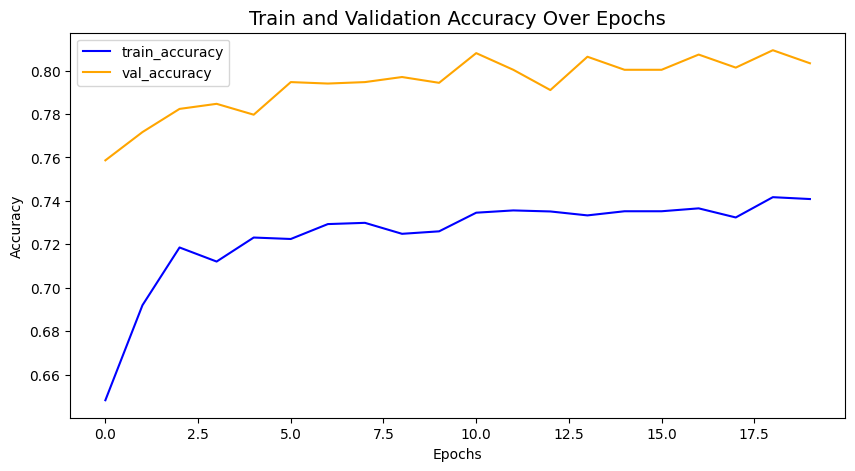

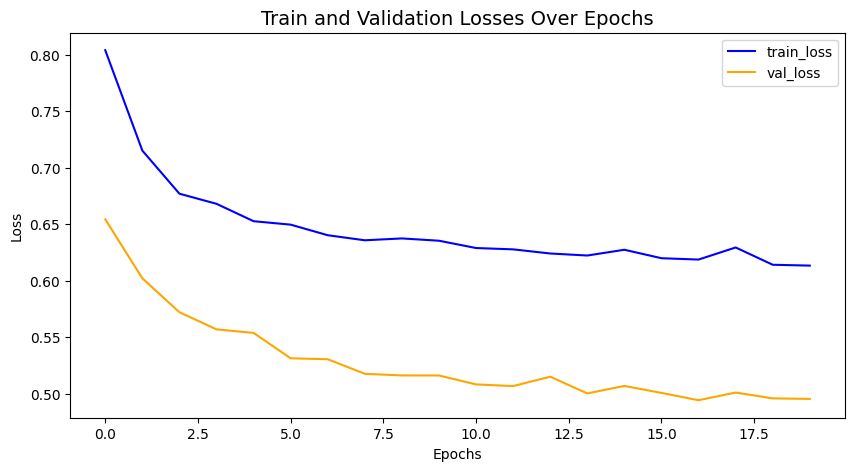

In [ ]:
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))

plt.plot(history.history["accuracy"], label="train_accuracy", color='blue')
plt.plot(history.history["val_accuracy"], label="val_accuracy", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy Over Epochs", fontsize=14)
plt.legend()

# Plot training and validation loss
plt.figure(figsize=(10, 5))

plt.plot(history.history["loss"], label="train_loss", color='blue')
plt.plot(history.history["val_loss"], label="val_loss", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()

plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step


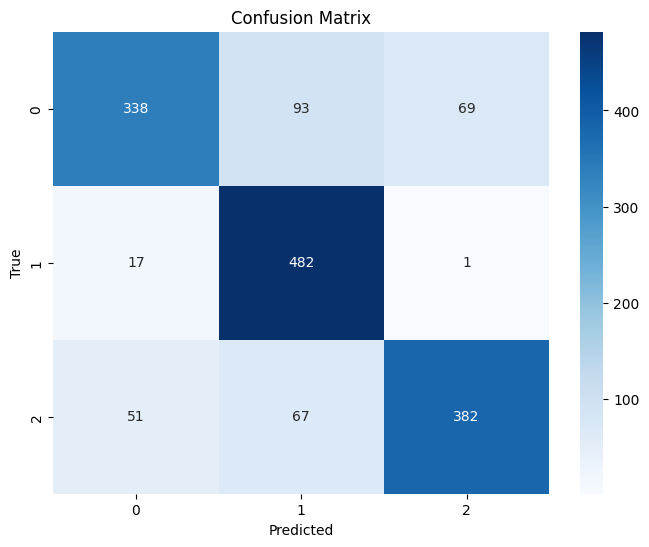

              precision    recall  f1-score   support

           0       0.83      0.68      0.75       500
           1       0.75      0.96      0.84       500
           2       0.85      0.76      0.80       500

    accuracy                           0.80      1500
   macro avg       0.81      0.80      0.80      1500
weighted avg       0.81      0.80      0.80      1500



In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions
y_pred = vgg16_model.predict(test_set)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class labels

# Extract true labels from test_set
y_true = np.concatenate([y for x, y in test_set], axis=0)  # Get true labels as one array
y_true_classes = np.argmax(y_true, axis=1)  # Convert one-hot to class indices

# Generate a confusion matrix
confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=[str(i) for i in range(3)],
            yticklabels=[str(i) for i in range(3)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
class_report = classification_report(y_true_classes, y_pred_classes)
print(class_report)


## 2) Res-Net50

In [ ]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_resnet.trainable = False

x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

resnet_model = Model(inputs=base_model_resnet.input, outputs=output)
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
filepath = "/content/ResNet50.weights.h5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                               save_weights_only=True, save_best_only=True, mode='max', save_freq= 2)

log_csv = CSVLogger('/content/ResNet50.csv', separator=',', append=False)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

callbacks_list = [checkpoint1, log_csv, early_stopping]

resnet_history = resnet_model.fit(
    training_set,
    epochs=20,
    validation_data=val_set,
    callbacks = callbacks_list,
    verbose = 1
)

Epoch 1/20
  2/165 ━━━━━━━━━━━━━━━━━━━━ 1:24:19 31s/step - accuracy: 0.3672 - loss: 1.4674

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:202: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.5214 - loss: 1.0417 - val_accuracy: 0.6167 - val_loss: 0.8391
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 80s 206ms/step - accuracy: 0.5898 - loss: 0.8944 - val_accuracy: 0.6163 - val_loss: 0.8301
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 33s 201ms/step - accuracy: 0.5956 - loss: 0.8843 - val_accuracy: 0.6267 - val_loss: 0.8330
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 35s 215ms/step - accuracy: 0.6020 - loss: 0.8825 - val_accuracy: 0.6393 - val_loss: 0.8128
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 34s 206ms/step - accuracy: 0.6128 - loss: 0.8485 - val_accuracy: 0.6700 - val_loss: 0.7381
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 33s 198ms/step - accuracy: 0.6120 - loss: 0.8467 - val_accuracy: 0.6323 - val_loss: 0.8191
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 39s 185ms/step - accuracy: 0.6201 - loss: 0.8595 - val_accuracy: 0.6397 - val_loss: 0.8222
Epoch 8/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 32s 193ms/step - accuracy: 0.6248 - loss: 0.8438 - val_a

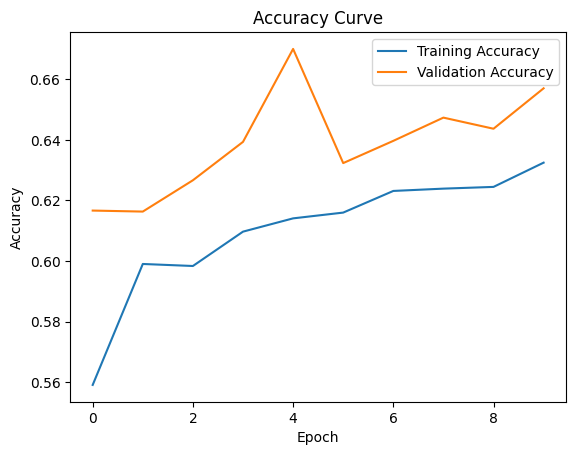

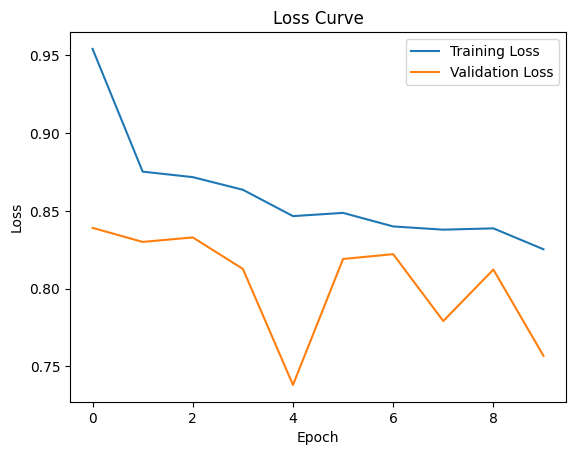

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV file
data = pd.read_csv('/content/ResNet50.csv')

# Plot accuracy
plt.plot(data['epoch'], data['accuracy'], label='Training Accuracy')
plt.plot(data['epoch'], data['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(data['epoch'], data['loss'], label='Training Loss')
plt.plot(data['epoch'], data['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step


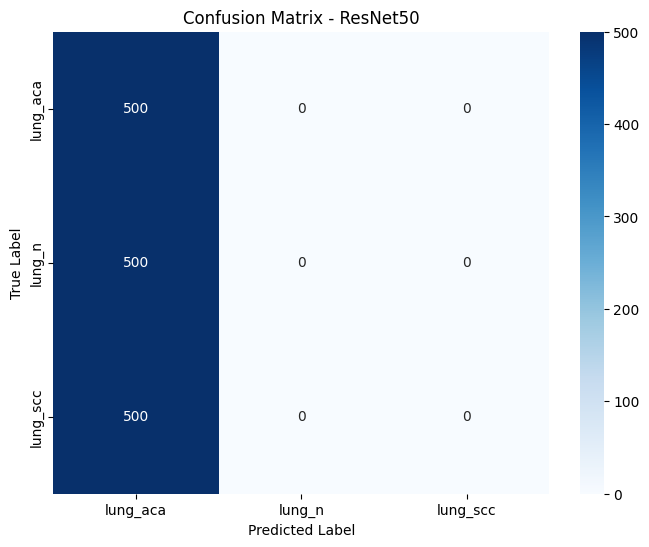

              precision    recall  f1-score   support

    lung_aca       0.33      1.00      0.50       500
      lung_n       0.00      0.00      0.00       500
    lung_scc       0.00      0.00      0.00       500

    accuracy                           0.33      1500
   macro avg       0.11      0.33      0.17      1500
weighted avg       0.11      0.33      0.17      1500



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = resnet_model.predict(test_set)

y_true = np.concatenate([y.numpy() for _, y in test_set], axis=0)  # Convert tensor to NumPy
y_true_classes = np.argmax(y_true, axis=1)  # Convert one-hot labels to class indices

class_names = ['lung_aca', 'lung_n', 'lung_scc']

conf_matrix = confusion_matrix(y_true_classes, np.argmax(y_pred, axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ResNet50")
plt.show()

print(classification_report(y_true_classes, np.argmax(y_pred, axis=1), target_names=class_names))

## 3) EfficientNetB0

In [ ]:
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_efficientnet.trainable = False

x = base_model_efficientnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

efficientnet_model = Model(inputs=base_model_efficientnet.input, outputs=output)
efficientnet_model.summary()

efficientnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
filepath = "/content/EfficientNetB0.weights.h5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                               save_weights_only=True, save_best_only=True, mode='max', save_freq= 'epoch')

log_csv = CSVLogger('/content/EfficientNetB0.csv', separator=',', append=False)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

callbacks_list = [checkpoint1, log_csv, early_stopping]

efficient_history = efficientnet_model.fit(
    training_set,
    epochs=20,
    validation_data=val_set,
    callbacks = callbacks_list,
    verbose = 1
)

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.3329 - loss: 1.2152
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to /content/EfficientNetB0.weights.h5
165/165 ━━━━━━━━━━━━━━━━━━━━ 176s 872ms/step - accuracy: 0.3330 - loss: 1.2150 - val_accuracy: 0.3333 - val_loss: 1.0885
Epoch 2/20
164/165 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3469 - loss: 1.1729
Epoch 2: val_accuracy did not improve from 0.33333
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.3469 - loss: 1.1730 - val_accuracy: 0.3327 - val_loss: 1.0868
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3482 - loss: 1.1746
Epoch 3: val_accuracy improved from 0.33333 to 0.39500, saving model to /content/EfficientNetB0.weights.h5
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.3483 - loss: 1.1746 - val_accuracy: 0.3950 - val_loss: 1.0781
Epoch 4/20
164/165 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3504 - loss: 1.1858
Epoch 4: val_accuracy did not 

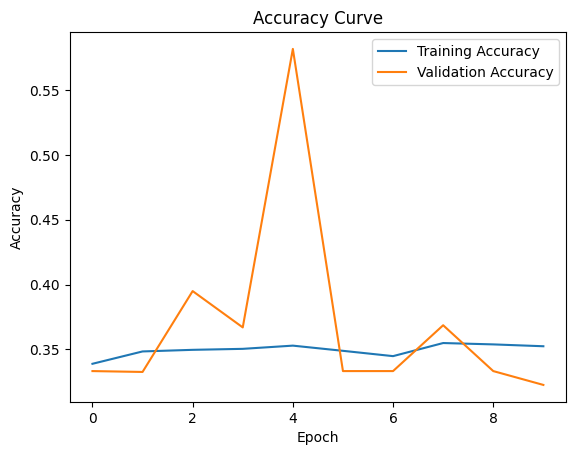

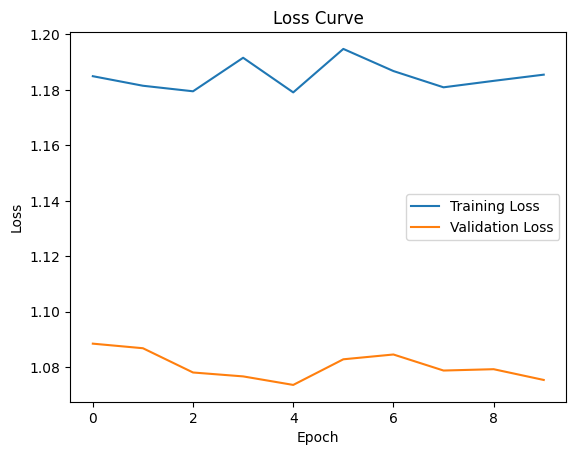

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV file
data = pd.read_csv('/content/EfficientNetB0.csv')

# Plot accuracy
plt.plot(data['epoch'], data['accuracy'], label='Training Accuracy')
plt.plot(data['epoch'], data['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(data['epoch'], data['loss'], label='Training Loss')
plt.plot(data['epoch'], data['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 619ms/step


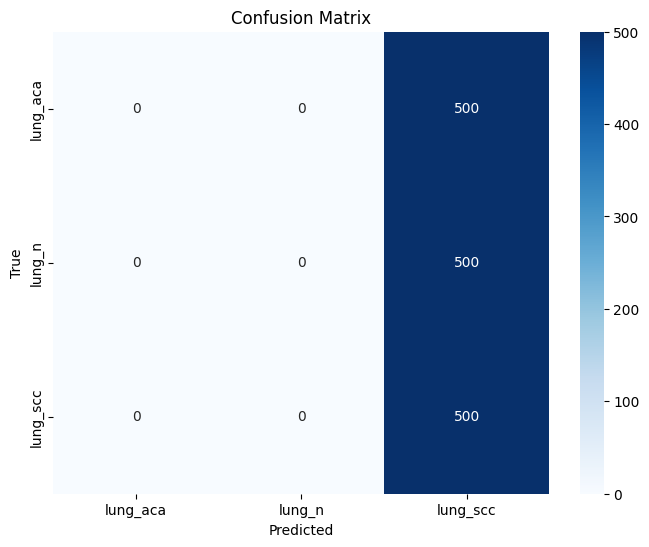

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       500
           1       0.00      0.00      0.00       500
           2       0.33      1.00      0.50       500

    accuracy                           0.33      1500
   macro avg       0.11      0.33      0.17      1500
weighted avg       0.11      0.33      0.17      1500



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = efficientnet_model.predict(test_set)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class labels

y_true = np.concatenate([y for x, y in test_set], axis=0)  # Get true labels as one array
y_true_classes = np.argmax(y_true, axis=1)  # Convert one-hot to class indices
class_names = ['lung_aca', 'lung_n', 'lung_scc']

# Generate a confusion matrix
confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
class_report = classification_report(y_true_classes, y_pred_classes)
print(class_report)


## 4) InceptionV3

In [ ]:
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_inception.trainable = False

x = base_model_inception.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

inception_model = Model(inputs=base_model_inception.input, outputs=output)
inception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

inception_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,808,931 (83.19 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
filepath = "/content/InceptionV3.weights.h5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                               save_weights_only=True, save_best_only=True, mode='max', save_freq='epoch')

log_csv = CSVLogger('/content/InceptionV3.csv', separator=',', append=False)

callbacks_list = [checkpoint1, log_csv]

inception_history = inception_model.fit(
    training_set,
    epochs=100,
    validation_data=val_set,
    callbacks = callbacks_list,
    verbose = 1
)

Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.6422 - loss: 1.7639
Epoch 1: val_accuracy improved from -inf to 0.68933, saving model to /content/InceptionV3.weights.h5
165/165 ━━━━━━━━━━━━━━━━━━━━ 179s 915ms/step - accuracy: 0.6426 - loss: 1.7599 - val_accuracy: 0.6893 - val_loss: 0.9783
Epoch 2/100
164/165 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7325 - loss: 0.9177
Epoch 2: val_accuracy did not improve from 0.68933
165/165 ━━━━━━━━━━━━━━━━━━━━ 26s 156ms/step - accuracy: 0.7327 - loss: 0.9171 - val_accuracy: 0.6320 - val_loss: 1.4001
Epoch 3/100
164/165 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7388 - loss: 0.9975
Epoch 3: val_accuracy improved from 0.68933 to 0.81467, saving model to /content/InceptionV3.weights.h5
165/165 ━━━━━━━━━━━━━━━━━━━━ 46s 188ms/step - accuracy: 0.7389 - loss: 0.9966 - val_accuracy: 0.8147 - val_loss: 0.5783
Epoch 4/100
164/165 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.7521 - loss: 0.9531
Epoch 4: val_accuracy did n

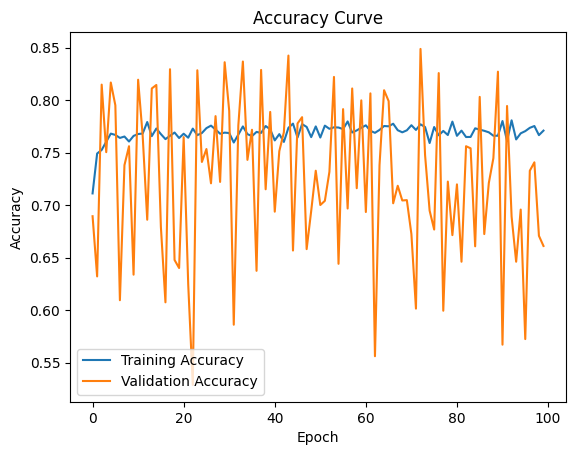

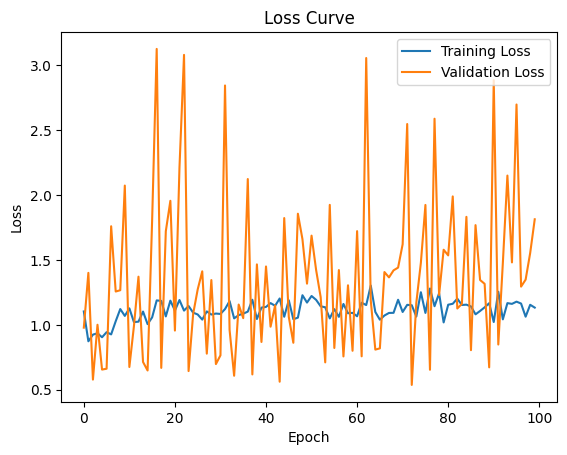

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV file
data = pd.read_csv('/content/InceptionV3.csv')

# Plot accuracy
plt.plot(data['epoch'], data['accuracy'], label='Training Accuracy')
plt.plot(data['epoch'], data['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(data['epoch'], data['loss'], label='Training Loss')
plt.plot(data['epoch'], data['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 244s 9s/step


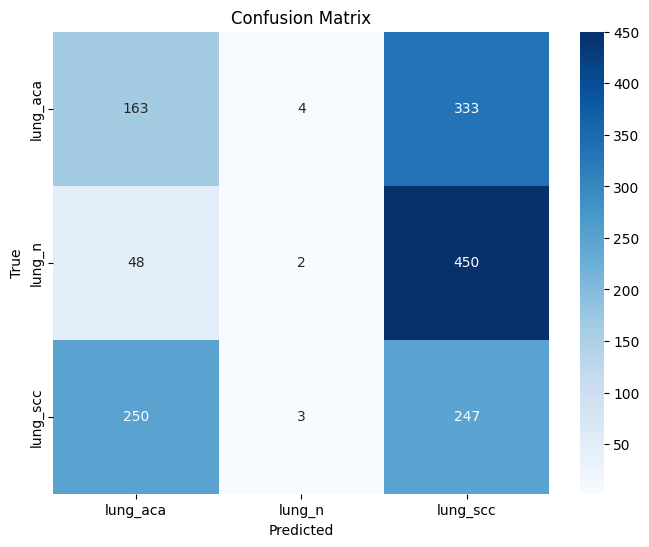

              precision    recall  f1-score   support

           0       0.35      0.33      0.34       500
           1       0.22      0.00      0.01       500
           2       0.24      0.49      0.32       500

    accuracy                           0.27      1500
   macro avg       0.27      0.27      0.22      1500
weighted avg       0.27      0.27      0.22      1500



In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = inception_model.predict(test_set)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class labels

y_true = np.concatenate([y for x, y in test_set], axis=0)  # Get true labels as one array
y_true_classes = np.argmax(y_true, axis=1)  # Convert one-hot to class indices
class_names = ['lung_aca', 'lung_n', 'lung_scc']

# Generate a confusion matrix
confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
class_report = classification_report(y_true_classes, y_pred_classes)
print(class_report)

## 5) MobileNetV2

In [ ]:
base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_mobilenet.trainable = False

x = base_model_mobilenet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

mobilenet_model = Model(inputs=base_model_mobilenet.input, outputs=output)
mobilenet_model.summary()

mobilenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
filepath = "/content/MobileNetV2.weights.h5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                               save_weights_only=True, save_best_only=True, mode='max', save_freq=2)

log_csv = CSVLogger('/content/MobileNetV2.csv', separator=',', append=False)

callbacks_list = [checkpoint1, log_csv]

mobilenet_history  = mobilenet_model.fit(
                                        training_set,
                                        epochs=20,
                                        validation_data=val_set,
                                        callbacks = callbacks_list,
                                        verbose = 1)

Epoch 1/20
  2/165 ━━━━━━━━━━━━━━━━━━━━ 1:37:34 36s/step - accuracy: 0.3242 - loss: 1.9175

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:202: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.6640 - loss: 0.8449 - val_accuracy: 0.8200 - val_loss: 0.4248
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 67s 59ms/step - accuracy: 0.7513 - loss: 0.6315 - val_accuracy: 0.8340 - val_loss: 0.3945
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.7583 - loss: 0.6381 - val_accuracy: 0.8050 - val_loss: 0.4608
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.7632 - loss: 0.6402 - val_accuracy: 0.8297 - val_loss: 0.3984
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.7798 - loss: 0.5871 - val_accuracy: 0.8330 - val_loss: 0.4077
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.7642 - loss: 0.6502 - val_accuracy: 0.8363 - val_loss: 0.4025
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.7725 - loss: 0.6290 - val_accuracy: 0.8393 - val_loss: 0.4253
Epoch 8/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.7690 - loss: 0.6385 - val_accuracy

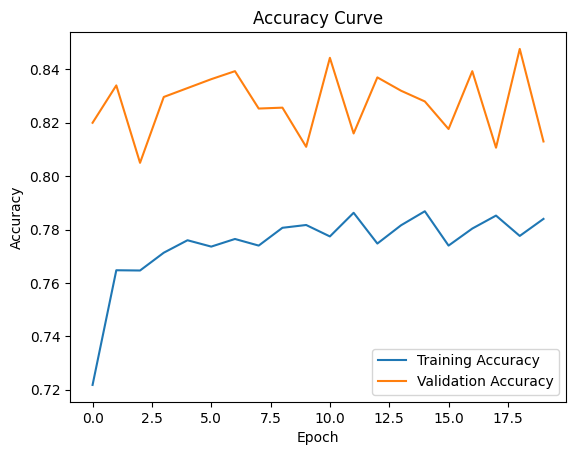

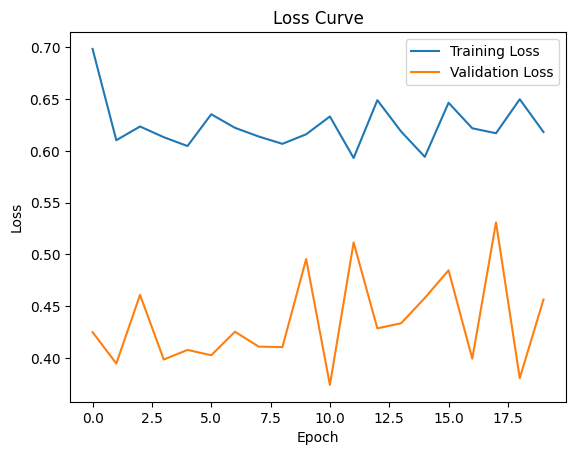

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV file
data = pd.read_csv('/content/MobileNetV2.csv')

# Plot accuracy
plt.plot(data['epoch'], data['accuracy'], label='Training Accuracy')
plt.plot(data['epoch'], data['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(data['epoch'], data['loss'], label='Training Loss')
plt.plot(data['epoch'], data['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 257s 11s/step


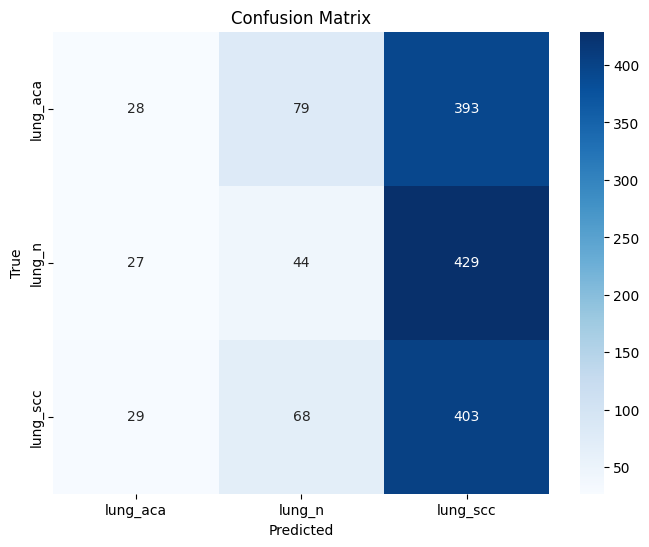

              precision    recall  f1-score   support

           0       0.33      0.06      0.10       500
           1       0.23      0.09      0.13       500
           2       0.33      0.81      0.47       500

    accuracy                           0.32      1500
   macro avg       0.30      0.32      0.23      1500
weighted avg       0.30      0.32      0.23      1500



In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = mobilenet_model.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y for x, y in test_set], axis=0)
y_true_classes = np.argmax(y_true, axis=1)
class_names = ['lung_aca', 'lung_n', 'lung_scc']

confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_true_classes, y_pred_classes)
print(class_report)

## Ther best model for our dataset is VGG16. Next, We will have our ablution study for this model.

The aim of the ablation study is to gain a deeper understanding of the **VGG16 transfer learning model's** performance by systematically modifying key components. By altering different factors such as **dropout rate, global pooling strategy, loss functions, optimizers, learning rate, and batch size**, the impact of each change on classification accuracy is analyzed. This stepwise approach helps identify potential performance improvements or degradations, allowing for better optimization and fine-tuning of the model to achieve optimal results.

# Part 03: Ablation Study for VGG16

##  1. changing dropout rate

0.3, which is optimal. That's why we will use 0.3 as our dropout rate

In [ ]:
# Load the base VGG16 model
best_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
best_model.trainable = False

x = best_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(3, activation='softmax')(x)

model = Model(inputs=best_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,6

 Total params: 14,978,883 (57.14 MB)

 Trainable params: 264,195 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
filepath = "/content/best_model.weights.h5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                               save_weights_only=True, save_best_only=True, mode='max', save_freq=2)

log_csv = CSVLogger('/content/best_model.csv', separator=',', append=False)

callbacks_list = [checkpoint1, log_csv]

history = model.fit(
    training_set,
    epochs=10,
    validation_data=val_set,
    callbacks = callbacks_list,
    verbose = 1
)

Epoch 1/10
  2/165 ━━━━━━━━━━━━━━━━━━━━ 1:30:43 33s/step - accuracy: 0.3633 - loss: 1.9338

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:202: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 837s 5s/step - accuracy: 0.6269 - loss: 0.9549 - val_accuracy: 0.7593 - val_loss: 0.5495
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 58s 349ms/step - accuracy: 0.7819 - loss: 0.5026 - val_accuracy: 0.8080 - val_loss: 0.4481
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 57s 346ms/step - accuracy: 0.8157 - loss: 0.4359 - val_accuracy: 0.8310 - val_loss: 0.3864
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 57s 345ms/step - accuracy: 0.8256 - loss: 0.4199 - val_accuracy: 0.8470 - val_loss: 0.3559
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 57s 346ms/step - accuracy: 0.8297 - loss: 0.3995 - val_accuracy: 0.8583 - val_loss: 0.3422
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 82s 349ms/step - accuracy: 0.8343 - loss: 0.4012 - val_accuracy: 0.8613 - val_loss: 0.3345
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 57s 345ms/step - accuracy: 0.8390 - loss: 0.3887 - val_accuracy: 0.8410 - val_loss: 0.3609
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 57s 346ms/step - accuracy: 0.8313 - loss: 0.4165 - val_a

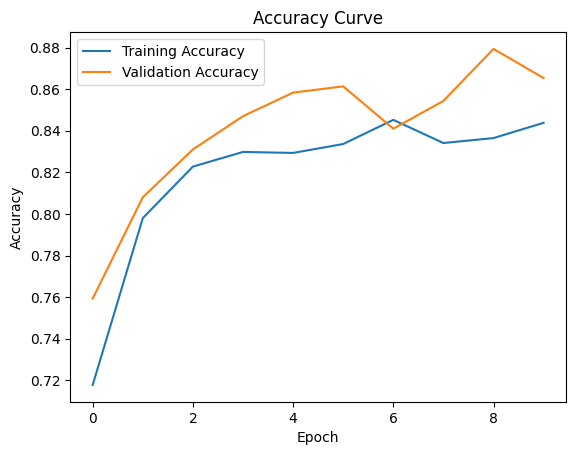

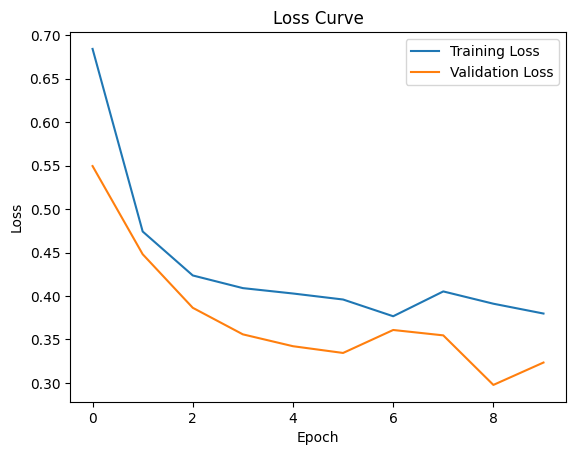

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV file
data = pd.read_csv('/content/best_model.csv')

# Plot accuracy
plt.plot(data['epoch'], data['accuracy'], label='Training Accuracy')
plt.plot(data['epoch'], data['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(data['epoch'], data['loss'], label='Training Loss')
plt.plot(data['epoch'], data['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 2. changing Global Pooling Strategy

In [ ]:
best_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
best_model.trainable = False

x = best_model.output
x = GlobalMaxPooling2D()(x)  # Changed pooling strategy
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(3, activation='softmax')(x)

model = Model(inputs=best_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate = 0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 512)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,6

 Total params: 14,978,883 (57.14 MB)

 Trainable params: 264,195 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
filepath = "/content/best_model.weights.h5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                               save_weights_only=True, save_best_only=True, mode='max', save_freq='epoch')

log_csv = CSVLogger('/content/best_model.csv', separator=',', append=False)

callbacks_list = [checkpoint1, log_csv]

history = model.fit(
    training_set,
    epochs=10,
    validation_data=val_set,
    callbacks = callbacks_list,
    verbose = 1
)

Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5366 - loss: 1.9580
Epoch 1: val_accuracy improved from -inf to 0.75867, saving model to /content/best_model.weights.h5
164/164 ━━━━━━━━━━━━━━━━━━━━ 2102s 13s/step - accuracy: 0.5373 - loss: 1.9524 - val_accuracy: 0.7587 - val_loss: 0.5879
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.7468 - loss: 0.6043
Epoch 2: val_accuracy improved from 0.75867 to 0.79433, saving model to /content/best_model.weights.h5
164/164 ━━━━━━━━━━━━━━━━━━━━ 57s 349ms/step - accuracy: 0.7468 - loss: 0.6041 - val_accuracy: 0.7943 - val_loss: 0.4798
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7512 - loss: 0.5766
Epoch 3: val_accuracy improved from 0.79433 to 0.79767, saving model to /content/best_model.weights.h5
164/164 ━━━━━━━━━━━━━━━━━━━━ 60s 365ms/step - accuracy: 0.7512 - loss: 0.5766 - val_accuracy: 0.7977 - val_loss: 0.4934
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.7503 

Therefore we must use Global Average Pooling as MaxPooling is not effective here that much.

## 3. changing Loss Functions

In [ ]:
best_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
best_model.trainable = False

x = best_model.output
x = GlobalMaxPooling2D()(x)  # Changed pooling strategy
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(3, activation='softmax')(x)

model = Model(inputs=best_model.input, outputs=output_layer)

# Change loss function to sparse_categorical_crossentropy
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None, 5), output.shape=(None, 5)

The loss function is changed back to categorical_crossentropy which is the correct loss function to use with one-hot encoded target variables. This will resolve the shape mismatch error.


## 4. changing Optimizer

Experimenting with SGD.

In [ ]:
best_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
best_model.trainable = False

x = best_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(3, activation='softmax')(x)

model = Model(inputs=best_model.input, outputs=output_layer)

#Optimizer changed to SGD
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,6

 Total params: 14,978,883 (57.14 MB)

 Trainable params: 264,195 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
filepath = "/content/sgd.weights.h5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                               save_weights_only=True, save_best_only=True, mode='max', save_freq=2)

log_csv = CSVLogger('/content/sgd.csv', separator=',', append=False)

callbacks_list = [checkpoint1, log_csv]

history = model.fit(
    training_set,
    epochs=10,
    validation_data=val_set,
    callbacks = callbacks_list,
    verbose = 1
)

Epoch 1/10
  2/165 ━━━━━━━━━━━━━━━━━━━━ 54:24 20s/step - accuracy: 0.3555 - loss: 1.1166

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV file
data = pd.read_csv('/content/sgd.csv')

# Plot accuracy
plt.plot(data['epoch'], data['accuracy'], label='Training Accuracy')
plt.plot(data['epoch'], data['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(data['epoch'], data['loss'], label='Training Loss')
plt.plot(data['epoch'], data['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Experimenting with Nadam.

In [ ]:
best_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
best_model.trainable = False

x = best_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(3, activation='softmax')(x)

model = Model(inputs=best_model.input, outputs=output_layer)

#Optimizer changed to Nadam
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │         262,6

 Total params: 14,978,883 (57.14 MB)

 Trainable params: 264,195 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
filepath = "/content/nadam.weights.h5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                               save_weights_only=True, save_best_only=True, mode='max')

log_csv = CSVLogger('/content/nadam.csv', separator=',', append=False)

callbacks_list = [checkpoint1, log_csv]

history = model.fit(
    training_set,
    epochs=10,
    validation_data=val_set,
    callbacks = callbacks_list,
    verbose = 1
)

Epoch 1/10
 62/165 ━━━━━━━━━━━━━━━━━━━━ 39:25 23s/step - accuracy: 0.6447 - loss: 0.8022

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV file
data = pd.read_csv('/content/nadam.csv')

# Plot accuracy
plt.plot(data['epoch'], data['accuracy'], label='Training Accuracy')
plt.plot(data['epoch'], data['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(data['epoch'], data['loss'], label='Training Loss')
plt.plot(data['epoch'], data['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

So, SGD is not optimal here.

## 5. changing Learning Rate

In [ ]:
best_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
best_model.trainable = False

x = best_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(3, activation='softmax')(x)

model = Model(inputs=best_model.input, outputs=output_layer)

# Change learning rate to 0.0001
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         262,6

 Total params: 14,978,883 (57.14 MB)

 Trainable params: 264,195 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## 6. changing batch size

In [ ]:
history_batch = model.fit(training_set, validation_data=val_set, epochs=10, batch_size=128)

I run with 128 batch size and got not impactful for my project. We should skip it.

# Exploring 5 transfer Learning Model's Exploration


# Part 04: Model Evaluation and Visualization

In [ ]:
from tensorflow.keras.regularizers import l2

best_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
best_model.trainable = False

# Add custom layers
x = best_model.output
x = GlobalAveragePooling2D()(x)  # Best pooling strategy
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)  # Best dropout rate
output_layer = Dense(3, activation='softmax')(x)  # 3 classes

# Create final model
model = Model(inputs=best_model.input, outputs=output_layer)
model.summary()

# Compile the model with optimal settings
model.compile(optimizer=Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         131,3

 Total params: 14,846,787 (56.64 MB)

 Trainable params: 132,099 (516.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

using a learning rate scheduler:

In [ ]:
filepath = "/content/best_model.weights.h5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                               save_weights_only=True, save_best_only=True, mode='max', save_freq=2)

log_csv = CSVLogger('/content/best_model.csv', separator=',', append=False)

callbacks_list = [checkpoint1, log_csv]

history = model.fit(
    training_set,
    epochs=10,
    validation_data=val_set,
    callbacks = callbacks_list,
    verbose = 1
)

Epoch 1/10
  2/165 ━━━━━━━━━━━━━━━━━━━━ 1:30:43 33s/step - accuracy: 0.3633 - loss: 1.9338

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:202: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 837s 5s/step - accuracy: 0.6269 - loss: 0.9549 - val_accuracy: 0.7593 - val_loss: 0.5495
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 58s 349ms/step - accuracy: 0.7819 - loss: 0.5026 - val_accuracy: 0.8080 - val_loss: 0.4481
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 57s 346ms/step - accuracy: 0.8157 - loss: 0.4359 - val_accuracy: 0.8310 - val_loss: 0.3864
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 57s 345ms/step - accuracy: 0.8256 - loss: 0.4199 - val_accuracy: 0.8470 - val_loss: 0.3559
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 57s 346ms/step - accuracy: 0.8297 - loss: 0.3995 - val_accuracy: 0.8583 - val_loss: 0.3422
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 82s 349ms/step - accuracy: 0.8343 - loss: 0.4012 - val_accuracy: 0.8613 - val_loss: 0.3345
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 57s 345ms/step - accuracy: 0.8390 - loss: 0.3887 - val_accuracy: 0.8410 - val_loss: 0.3609
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 57s 346ms/step - accuracy: 0.8313 - loss: 0.4165 - val_a

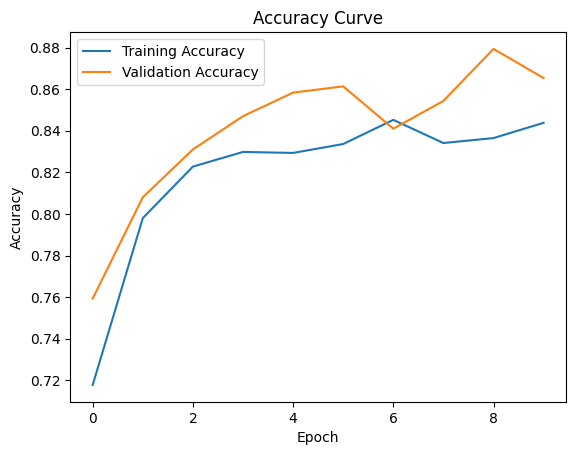

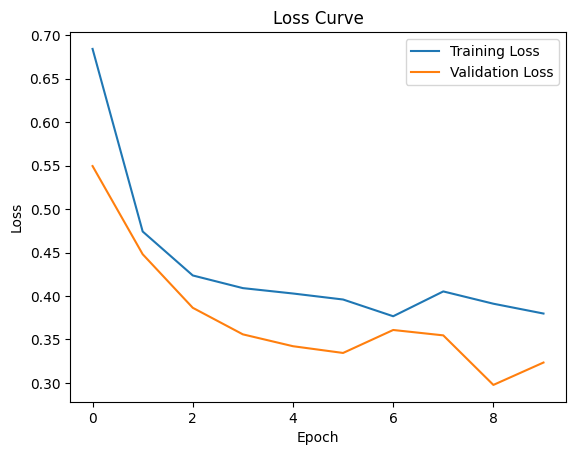

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV file
data = pd.read_csv('/content/best_model.csv')

# Plot accuracy
plt.plot(data['epoch'], data['accuracy'], label='Training Accuracy')
plt.plot(data['epoch'], data['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(data['epoch'], data['loss'], label='Training Loss')
plt.plot(data['epoch'], data['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step


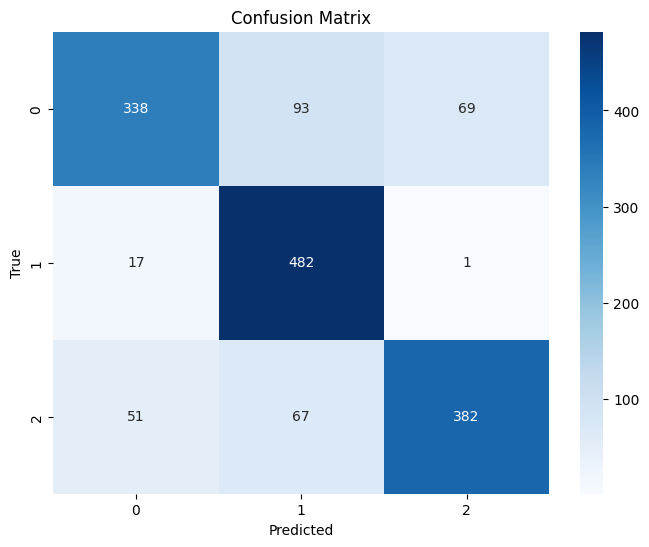

              precision    recall  f1-score   support

           0       0.83      0.68      0.75       500
           1       0.75      0.96      0.84       500
           2       0.85      0.76      0.80       500

    accuracy                           0.80      1500
   macro avg       0.81      0.80      0.80      1500
weighted avg       0.81      0.80      0.80      1500



In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions
y_pred = vgg16_model.predict(test_set)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class labels

# Extract true labels from test_set
y_true = np.concatenate([y for x, y in test_set], axis=0)  # Get true labels as one array
y_true_classes = np.argmax(y_true, axis=1)  # Convert one-hot to class indices

# Generate a confusion matrix
confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=[str(i) for i in range(3)],
            yticklabels=[str(i) for i in range(3)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
class_report = classification_report(y_true_classes, y_pred_classes)
print(class_report)
